In [389]:
from fredapi import Fred
fred = Fred(api_key='YOUR API')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import datetime
import macro_indicators_toolkit as mitk
import fedor_levin_toolkit as fltk
%load_ext autoreload
%autoreload 2

from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xgb
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot
import sklearn
import matplotlib.patches as mpatches

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
recession = mitk.recession_nber() #monthly
T10YFFM_d = mitk.tenyear_cm_minus_fedfunds() #monthly
TB3SMFFM_d = mitk.three_month_tbill_minus_fedfunds() #monthly
PAYEMS_d = mitk.all_employee() #monthly
JTSJOL_d = mitk.job_open() #monthly
T5YFFM_d = mitk.five_year_cm_minus_fedfund() #monthly
T1YFFM_d = mitk.one_year_cm_minus_fedfund() #monthly
EXUSUK_d = mitk.us_uk_fx() #monthly
HOUSTW_d = mitk.housing_stats_west_census() #monthly
TB3MS_d = mitk.three_month_trs_secondary() #monthly
USCONS_d = mitk.employee_constr() #monthly
AWOTMAN_d = mitk.overtime_manuf() #monthly
HOUST_d = mitk.housing_owened() #monthly
DMANEMP_d = mitk.employee_durable() #monthly
SRVPRD_d = mitk.employee_service() #monthly
ICSA_d = mitk.initial_claims() #daily
ICSA_d = ICSA_d.resample('M').mean() #resampling daily to monthly
UNRATE_d = mitk.unemployment_rate_us() #monthly
sp500 = fltk.hist_returns(['^GSPC']) #daily
sp500_m = (1+sp500).resample('M').prod()-1 #resampling daily to monthly
sp500_m = sp500_m.rename(columns={'^GSPC': 'SP500_M'}) #changing column name
termspread = mitk.spread_tenyr_threemon_tr() #daily
termspread = termspread.resample('M').mean() #resampling daily to monthly
gdp = mitk.gdp_us() #quaterly
gdp = gdp.resample('M').mean() #resampling quaterly to monthly
gdp = gdp.interpolate(method='nearest') #interpolating gaps
gdp = gdp.pct_change() #percent change

In [23]:
macro_list = [recession, T10YFFM_d, TB3SMFFM_d, PAYEMS_d, JTSJOL_d, T5YFFM_d, T1YFFM_d, EXUSUK_d,
                     HOUSTW_d, TB3MS_d, USCONS_d, AWOTMAN_d, HOUST_d, DMANEMP_d, SRVPRD_d,
                     ICSA_d, UNRATE_d, sp500_m, termspread, gdp]
#indexing to months:
for i in macro_list:
    i.index = i.index.to_period('M')

bigmacro = pd.concat(macro_list, axis=1)
bigmacro = bigmacro['1981-08':]
bigmacro=bigmacro.drop(['JTSJOL'], axis=1)

In [24]:
bigmacro.head()

,USREC,T10YFFM,TB3SMFFM,PAYEMS,T5YFFM,T1YFFM,EXUSUK,HOUSTW,TB3MS,USCONS,AWOTMAN,HOUST,DMANEMP,SRVPRD,ICSA,UNRATE,SP500_M,TERMSPREAD,GDPC1
1981-08,1.0,-2.88,-2.31,91565.0,-2.26,-1.10,1.8203,213.0,15.51,4278.0,2.9,940.0,11696.0,67307.0,450200.0,7.4,-0.062099,NaN,0.000000
1981-09,1.0,-0.55,-1.17,91477.0,0.06,0.65,1.8146,198.0,14.70,4254.0,2.6,911.0,11668.0,67267.0,473250.0,7.6,-0.053832,-0.283333,-0.010895
1981-10,1.0,0.07,-1.54,91380.0,0.33,0.30,1.8407,222.0,13.54,4238.0,2.6,873.0,11558.0,67329.0,492800.0,7.9,0.049148,0.917143,0.000000
1981-11,1.0,0.08,-2.45,91171.0,0.07,-0.90,1.9025,163.0,10.86,4209.0,2.4,837.0,11425.0,67296.0,511750.0,8.3,0.036590,2.047222,0.000000
1981-12,1.0,1.35,-1.52,90895.0,1.23,0.48,1.9033,181.0,10.85,4177.0,2.4,910.0,11275.0,67239.0,551000.0,8.5,-0.030075,2.409524,-0.015535


In [25]:
bigmacro.groupby("USREC").count()

,T10YFFM,TB3SMFFM,PAYEMS,T5YFFM,T1YFFM,EXUSUK,HOUSTW,TB3MS,USCONS,AWOTMAN,HOUST,DMANEMP,SRVPRD,ICSA,UNRATE,SP500_M,TERMSPREAD,GDPC1
USREC,,,,,,,,,,,,,,,,,,
0.0,413,413,413,413,413,413,413,413,413,413,413,413,413,413,413,413,413,413
1.0,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,61,58


In [26]:
# Add lags
for col in bigmacro.drop(['USREC'], axis=1):
    for n in [3,6,9,12,18]:
        bigmacro['{} {}M lag'.format(col, n)] = bigmacro[col].shift(n).ffill().values

# 1 month ahead prediction
bigmacro["USREC"]=bigmacro["USREC"].shift(-1)
# dropping columns with missing values
bigmacro=bigmacro.dropna(axis=0)

In [27]:
bigmacro.head()

,USREC,T10YFFM,TB3SMFFM,PAYEMS,T5YFFM,T1YFFM,EXUSUK,HOUSTW,TB3MS,USCONS,...,TERMSPREAD 3M lag,TERMSPREAD 6M lag,TERMSPREAD 9M lag,TERMSPREAD 12M lag,TERMSPREAD 18M lag,GDPC1 3M lag,GDPC1 6M lag,GDPC1 9M lag,GDPC1 12M lag,GDPC1 18M lag
1983-03,0.0,1.74,-0.42,89090.0,1.31,0.27,1.4900,346.0,8.35,3942.0,...,2.337273,4.146190,1.220909,0.546522,-0.283333,0.013179,0.000399,-0.003823,0.004562,-0.010895
1983-04,0.0,1.60,-0.59,89364.0,1.22,0.18,1.5361,318.0,8.21,3948.0,...,2.340000,2.939000,2.082857,0.527143,0.917143,0.000000,0.000000,0.000000,0.000000,0.000000
1983-05,0.0,1.75,-0.44,89644.0,1.40,0.27,1.5722,399.0,8.19,3960.0,...,2.330526,2.204211,4.057727,0.908500,2.047222,0.000000,0.000000,0.000000,0.000000,0.000000
1983-06,0.0,1.87,-0.19,90021.0,1.65,0.68,1.5480,424.0,8.79,4006.0,...,1.846957,2.337273,4.146190,1.220909,2.409524,0.022756,0.013179,0.000399,-0.003823,-0.015535
1983-07,0.0,2.01,-0.29,90437.0,1.84,0.83,1.5273,425.0,9.08,4055.0,...,1.886500,2.340000,2.939000,2.082857,1.676000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
# Standardize
from sklearn.preprocessing import StandardScaler
features=bigmacro.drop(['USREC'],axis=1)
col_names=features.columns

scaler=StandardScaler()
scaler.fit(features)
standardized_features=scaler.transform(features)
standardized_features.shape
df=pd.DataFrame(data=standardized_features,columns=col_names)
df.insert(loc=0,column="Date", value=bigmacro.index)
df.insert(loc=1,column='Regime', value=bigmacro['USREC'].values)
df.head()
#df.shape

,Date,Regime,T10YFFM,TB3SMFFM,PAYEMS,T5YFFM,T1YFFM,EXUSUK,HOUSTW,TB3MS,...,TERMSPREAD 3M lag,TERMSPREAD 6M lag,TERMSPREAD 9M lag,TERMSPREAD 12M lag,TERMSPREAD 18M lag,GDPC1 3M lag,GDPC1 6M lag,GDPC1 9M lag,GDPC1 12M lag,GDPC1 18M lag
0,1983-03,0.0,0.161830,-0.328138,-2.241288,0.275373,0.345935,-0.489611,0.061986,1.732153,...,0.526804,2.137764,-0.507106,-1.119973,-1.909313,1.489567,-0.260479,-1.260120,0.468051,-2.679950
1,1983-04,0.0,0.046857,-0.807950,-2.224165,0.182254,0.134983,-0.246684,-0.190832,1.682031,...,0.529264,1.051611,0.268926,-1.137470,-0.811213,-0.307429,-0.322022,-0.470814,-0.483655,-0.455803
2,1983-05,0.0,0.170042,-0.384587,-2.206667,0.368492,0.345935,-0.056452,0.540535,1.674870,...,0.520718,0.390493,2.046950,-0.793132,0.222493,-0.307429,-0.322022,-0.470814,-0.483655,-0.455803
3,1983-06,0.0,0.268590,0.321020,-2.183107,0.627154,1.306940,-0.183976,0.766266,1.889681,...,0.084550,0.510214,2.126595,-0.511049,0.553897,2.795536,1.708488,-0.388346,-1.281190,-3.627126
4,1983-07,0.0,0.383563,0.038777,-2.157110,0.823738,1.658528,-0.293056,0.775295,1.993506,...,0.120217,0.512668,1.039732,0.267228,-0.117072,-0.307429,-0.322022,-0.470814,-0.483655,-0.455803


### Splitting data into train and test set (data up to the end of 2009)

In [1084]:
df_train = df[:322].drop(['Date', 'Regime'], axis=1)
df_train_targ = df.iloc[:322, 1]
df_test = df[323:].drop(['Date', 'Regime'], axis=1)
df_test_targ = df.iloc[323:, 1]

In [1085]:
df_test

,T10YFFM,TB3SMFFM,PAYEMS,T5YFFM,T1YFFM,EXUSUK,HOUSTW,TB3MS,USCONS,AWOTMAN,...,TERMSPREAD 3M lag,TERMSPREAD 6M lag,TERMSPREAD 9M lag,TERMSPREAD 12M lag,TERMSPREAD 18M lag,GDPC1 3M lag,GDPC1 6M lag,GDPC1 9M lag,GDPC1 12M lag,GDPC1 18M lag
323,1.656472,0.800832,0.296419,1.227252,0.228739,-0.111256,-1.807063,-1.217908,-0.521940,-1.397226,...,1.440734,1.480100,1.199090,0.711361,0.300825,-0.307429,-0.322022,-0.470814,-0.483655,-0.455803
324,1.664685,0.829056,0.307730,1.268638,0.275617,-0.406352,-1.861239,-1.203587,-0.484615,-1.023530,...,1.607535,1.357135,1.583692,0.737455,0.672811,0.217248,1.370335,0.280949,-0.784043,-4.872904
325,1.730383,0.744383,0.322166,1.382450,0.299057,-0.261966,-2.086969,-1.200007,-0.468474,-0.649834,...,1.730316,1.388412,1.435548,0.886809,1.211268,-0.307429,-0.322022,-0.470814,-0.483655,-0.455803
326,1.377253,0.744383,0.355912,0.968589,0.111543,-0.611339,-2.041823,-1.200007,-0.501764,-0.276138,...,1.649612,1.421876,1.468501,1.200083,1.398416,-0.307429,-0.322022,-0.470814,-0.483655,-0.455803
327,1.213007,0.687935,0.347225,0.803045,0.041226,-0.559170,-2.077940,-1.214327,-0.505799,-0.649834,...,1.644968,1.588263,1.345457,1.585797,0.528970,0.949828,0.270835,1.796966,0.275944,-2.747619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,-0.733313,1.083074,0.805235,-0.811011,-0.052531,-1.742190,-0.416563,-1.200007,1.163735,-1.584074,...,-1.063134,-1.324937,-1.817897,-1.744819,-1.265479,-12.560699,-2.267481,0.739551,0.845060,1.024428
448,-0.831861,0.970177,0.913097,-0.883437,-0.146287,-1.648392,-0.281125,-1.210747,1.189963,-0.836682,...,-1.112762,-1.408056,-1.580948,-1.691012,-1.384874,-0.307429,-0.322022,-0.470814,-0.483655,-0.455803
449,-0.807224,0.885504,1.012023,-0.893783,-0.193166,-1.415476,0.025869,-1.221488,1.216192,-0.649834,...,-1.088430,-1.629179,-1.390243,-1.942191,-1.432054,-0.307429,-0.322022,-0.470814,-0.483655,-0.455803
450,-0.782587,0.913729,1.056768,-0.893783,-0.193166,-1.518760,0.107132,-1.217908,1.249481,-0.649834,...,-1.068054,-1.075776,-1.338367,-1.825631,-1.542990,9.890416,-14.167557,-3.077755,0.739327,0.300960


### Fitting the model into Train set

In [1138]:
model=LogisticRegression(C=0.029, penalty='l2', class_weight={0: 0.15, 1: 0.85}) # high weight to recession 
LR=model.fit(df_train,df_train_targ)
training_predictions=LR.predict(df_train)
predictions=LR.predict(df_test)
prob_predictions = LR.predict_proba(df_test)

In [1139]:
print(f'Accuracy Score: {accuracy_score(df_test_targ,predictions)}')
print(f'Confusion Matrix: \n{confusion_matrix(df_test_targ, predictions)}')
print(f'Area Under Curve: {roc_auc_score(df_test_targ, predictions)}')
print(f'Recall score: {recall_score(df_test_targ,predictions)}')
print(f'Precision score: {precision_score(df_test_targ,predictions)}')

Accuracy Score: 0.9767441860465116
Confusion Matrix: 
[[118   2]
 [  1   8]]
Area Under Curve: 0.936111111111111
Recall score: 0.8888888888888888
Precision score: 0.8


### Predicting Regime on the whole dataset:

In [1140]:
all_predictions = LR.predict_proba(df.drop(['Date', 'Regime'], axis=1))
res = pd.concat([df[['Date', 'Regime']], pd.DataFrame(all_predictions)], axis=1)
res = res.set_index('Date')

Text(0, 0.5, 'Probability')

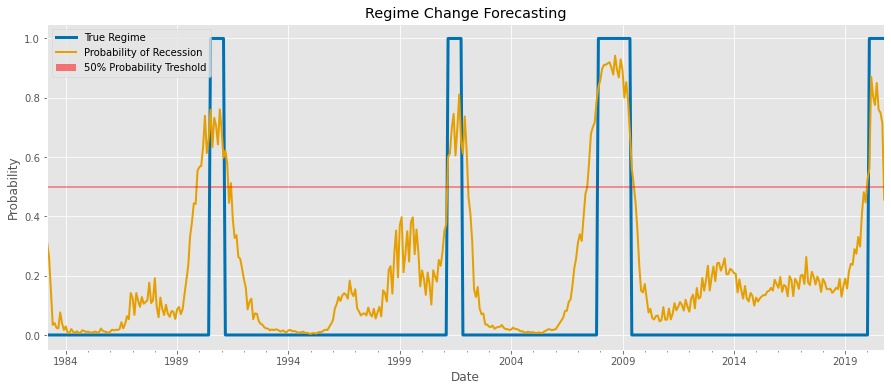

In [1287]:
plt.style.use('ggplot')
ax = res['Regime'].plot(figsize=(15,6), label='True Regime', color='#0072B2', linewidth=3)
res[1].plot(ax=ax, label='Probability of Recession', color='#E69F00', linewidth=2)
#btr[0]['floor'].plot(ax=ax, style="--")
#ax.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
a = plt.axhline(y=0.5, color='r', alpha = 0.5)
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
patch = mpatches.Patch( color='r', label='50% Probability Treshold', alpha = 0.5, ls="--", lw=0)

# handles is a list, so append manual patch
handles.append(patch) 
plt.legend(handles=handles, loc='upper left', fontsize=10)
plt.title('Regime Change Forecasting')
plt.ylabel('Probability')

In [1291]:
# get importance
importance = LR.coef_[0]

<AxesSubplot:>

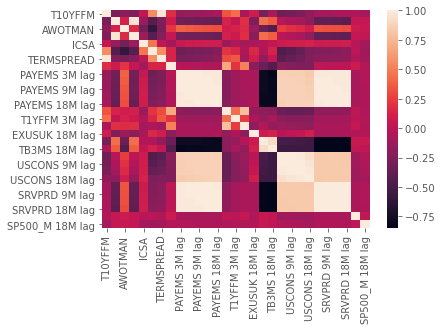

In [1184]:
sns.heatmap(df[most_imp['Feature'].values.tolist()].corr())

## Final Model

In [1279]:
#removing highly correlated features
exclude = ['T10YFFM', 'PAYEMS 3M lag', 'PAYEMS 9M lag', 'PAYEMS 12M lag', 'PAYEMS 6M lag', 'SRVPRD 9M lag', 
           'PAYEMS', 'USCONS 12M lag', 'USCONS 3M lag', 'USCONS 6M lag', 'USCONS 9M lag', 'SRVPRD','USCONS',
           'SRVPRD 3M lag', 'T5YFFM 18M lag', '', 'SRVPRD 6M lag', 'HOUSTW', 'SRVPRD 18M lag', 'SRVPRD 12M lag']
df_new = df.drop(exclude, axis=1)

In [1280]:
df_train = df_new[:322].drop(['Date', 'Regime'], axis=1)
df_train_targ = df_new.iloc[:322, 1]
df_test = df_new[323:].drop(['Date', 'Regime'], axis=1)
df_test_targ = df_new.iloc[323:, 1]

In [1281]:
model=LogisticRegression(C=0.029, penalty='l2', class_weight={0: 0.15, 1: 0.85}) # high weight to recession 
LR=model.fit(df_train,df_train_targ)
training_predictions=LR.predict(df_train)
predictions=LR.predict(df_test)
prob_predictions = LR.predict_proba(df_test)
print(f'Accuracy Score: {accuracy_score(df_test_targ,predictions)}')
print(f'Confusion Matrix: \n{confusion_matrix(df_test_targ, predictions)}')
print(f'Area Under Curve: {roc_auc_score(df_test_targ, predictions)}')
print(f'Recall score: {recall_score(df_test_targ,predictions)}')
print(f'Precision score: {precision_score(df_test_targ,predictions)}')

Accuracy Score: 0.9844961240310077
Confusion Matrix: 
[[119   1]
 [  1   8]]
Area Under Curve: 0.9402777777777778
Recall score: 0.8888888888888888
Precision score: 0.8888888888888888


In [1282]:
all_predictions = LR.predict_proba(df_new.drop(['Date', 'Regime'], axis=1))
res = pd.concat([df_new[['Date', 'Regime']], pd.DataFrame(all_predictions)], axis=1)
res = res.set_index('Date')

Text(0, 0.5, 'Probability')

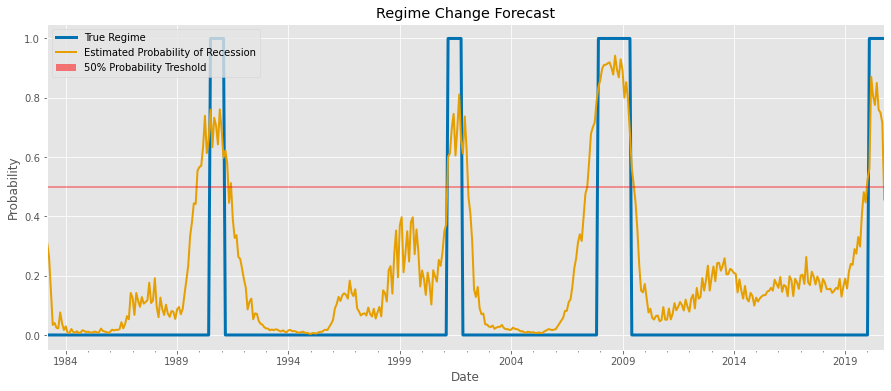

In [1305]:
plt.style.use('ggplot')
ax = res['Regime'].plot(figsize=(15,6), label='True Regime', color='#0072B2', linewidth=3)
res[1].plot(ax=ax, label='Estimated Probability of Recession', color='#E69F00', linewidth=2)
#btr[0]['floor'].plot(ax=ax, style="--")
#ax.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
a = plt.axhline(y=0.5, color='r', alpha = 0.5)
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
patch = mpatches.Patch( color='r', label='50% Probability Treshold', alpha = 0.5, ls="--", lw=0)

# handles is a list, so append manual patch
handles.append(patch) 
plt.legend(handles=handles, loc='upper left', fontsize=10)
plt.title('Regime Change Forecast')
plt.ylabel('Probability')

Text(0, 0.5, 'Importance')

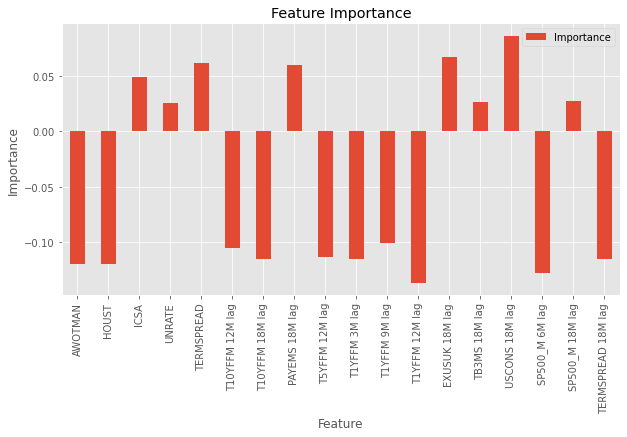

In [1309]:
# get importance
importance = LR.coef_[0]
feature_imp = pd.DataFrame({'Feature': df_new.drop(['Date', 'Regime'], axis=1).columns.to_list(), 'Importance':importance})
most_imp = feature_imp[(feature_imp['Importance']>0.025)|(feature_imp['Importance']<-0.1)]
most_imp.set_index('Feature').plot(kind='bar', figsize=(10,5))
plt.title('Feature Importance')
plt.ylabel('Importance')

Text(0.5, 1.0, 'Feature Correlation')

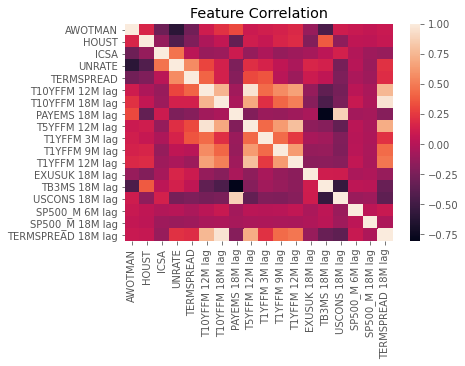

In [1308]:
sns.heatmap(df_new[most_imp['Feature'].values.tolist()].corr())
plt.title('Feature Correlation')
#plt.ylabel('Importance')